# 1 Multi-class Classification

In this exercise, we want to expand exercise 2 to multi-class classification. One easy way to implement that is using the One-vs-all algorithm. It transforms multi-class to double-class for each class, then run the normal logistic regression. For prediction it computes the probability of all classes, then choose the highest one.

## 1.1 Dataset

In `images`, each row is a "compressed" 20 by 20 gray image, and `numbers` consists the corresponding class (digit 0 to 9 where 0 is represented as 10 in this exercise).

In [23]:
using MAT
using Images, Colors

# Import the data from the .mat files
data = matread("data/ex3data1.mat")
images, numbers = data["X"], data["y"]

(
[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],

[10.0; 10.0; … ; 9.0; 9.0])

In [3]:
images

5000×400 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [4]:
numbers

5000×1 Array{Float64,2}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
  ⋮  
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0

## 1.2 Visualizing the data

To visualize the images, we can use the `Image.jl` package. In a scrip, we also need to use `ImageView.jl`, but `Image.jl` supports Jupyter image output directly.

To see the coorect image output, we need:
1. Restore the compressed array into the original image matrix.
2. Choose the correct size grid to display combined images.
3. Fill the small image matrix into the big triangle image matrix.
4. Display the triangle image matrix.

In [6]:
# The width of the small image
const WIDTH = convert(Int64, sqrt(length(images[1, :])))

# Reshape one row of the training example into a square matrix
function restore(row::Array{Float64, 1})
    width = convert(Int64,sqrt(length(row)))
    return  clamp01nan.(reshape(row, width, width))
end

restore (generic function with 1 method)

In [9]:
# Move one small image matrix into a bigger matrix at given position
function move_image!(row::Int64, col::Int64, square::Array{Float64, 2}, 
                    im::Array{Float64, 2})
    for i in 0:WIDTH-1
        for j in 0:WIDTH-1
            square[row + i, col + j] = im[i + 1, j + 1]
        end
    end
end

move_image! (generic function with 1 method)

In [10]:
# Convert image array into image object
get_image(im_array::Array) = colorview(Gray, im_array)

get_image (generic function with 1 method)

In [11]:
# Find the suitable grid matrix
function min_perimeter(total::Int64)
    min_a = min_b = start = convert(Int64, ceil(sqrt(total)))
    peri = Inf
    for a in convert(Int64, floor(start/2)):start
        for b in convert(Int64, floor(start/2)):start
            if (a + b) * 2 < peri && total <= a * b
                min_a, min_b = a, b
                peri = (a + b) * 2
            end
        end
    end
    return min_a, min_b
end

min_perimeter (generic function with 1 method)

In [12]:
# Display the images. `rows` is an array consisting the row number of the 
# images to display. The default is to randomly display 100 images.
function display_image(rows::Array = [])
    # Set up width and other variables
    if rows == []
        rows = rand(1:size(images, 1), 100)
    end

    if (tem_1 = sqrt(length(rows))) == (tem_2 = convert(Int64, ceil(tem_1)))
        width = len = tem_2
    else
        len, width =  min_perimeter(length(rows))
    end

    fill_num = length(rows) - width * len             

    # Preallocate a big square matrix
    square = Array{Float64}(len * WIDTH, width * WIDTH)
    row_cand = [i * WIDTH + 1 for i in 0:len-1]
    col_cand = [i * WIDTH + 1 for i in 0:width-1]
    i = 1
    
    # Moving small images into the big square in a loop
    for row in row_cand
        for col in col_cand
            if i <= length(rows)
                move_image!(row, col, square, restore(images[rows[i], :]))
                i += 1
            else
                # Fill the extra black squares
                move_image!(row, col, square, zeros(WIDTH, WIDTH))
            end
        end
    end
    
    get_image(square)
end

display_image (generic function with 2 methods)

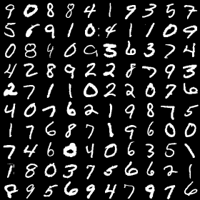

In [14]:
display_image()

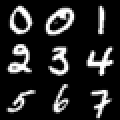

In [19]:
display_image([100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])

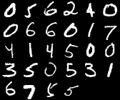

In [18]:
display_image(rand(1:4000, 28))

## 1.3 Vectorizing Logistic Regression

Since we have already used vectorized logistic regression implementation in exercise2, we can re-use the code in multi-class logistic regression. 

One thing to notice is `Optim.jl` requires user-provided gradient function `g!` to have excatly two arguments. For One-vs-all algorithm, we need to change the value matrix. Therefore we use the closure function to get cost and gradient.

In [20]:
# There are 10 classifiers in total
const NUM = 10

# Transform the images images into a standard feature matrix 
# Add a value 1 column into `images`
feature = hcat([1 for i in 1:size(images, 1)], images)

5000×401 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [21]:
# Define the logistic function, which supports both one-example-vector, or a
# training-set-matrix. x can be either a row vector or a column vector if x is
# just one training example, and this function assumes the first entry of the 
# vector is 1. If x is a training-set-matrix, then each row is one example, 
# and this function returns a n*1 matrix. If x is one-example-vector, this 
# function would return a Float rather than an array.
function h(Θ, x)
    # Single row vector
    if size(x, 1) == 1
        return 1 / (1 + e ^ -(x * Θ)[1])
    # Single column vector
    elseif size(x, 2) == 1
        return 1 / (1 + e ^ -(x' * Θ)[1])
    # Training set matrix
    else
        return result = map(z -> 1 / (1 + e ^ z), -(x * Θ))
    end
end

h (generic function with 1 method)

In [22]:
# `value` is  different for each classifier. One way to deal with it is to 
# pass `value` in a single cost() or g!() as an argument. However, `g!()` does 
# not support this method, so for the sake of consistence, we use closure here.
# The code below is modified a little bit from the ex2, now it takes `value` as
# an argument,
function cost_and_gradient(Θ, value, λ)
    m = size(feature, 1)
    return (Θ::Array) -> begin
        hypo = h(Θ, feature)
        pre = ((-value' * log(hypo) - (1 - value)' * log(1 - hypo)) / m)[1]
        return pre + ((λ / (2 * m)) * sum(Θ[2:end] .^ 2))
    end, (Θ::Array, storage::Array) -> begin
        hypo = h(Θ, feature)
        result = (feature' * (hypo - value)) / m
        storage[:] = result + (λ / m) * [0; Θ[2:end]]
    end
end

cost_and_gradient (generic function with 1 method)

## 1.4 One-vs-all Classification

Finally we can start the One-vs-all classification training process. We just implement the following:
1. Change multi-class to double-class
2. Run normal double-class logistic regression for each double-class case
3. Record the result